In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
plt.rcParams['figure.figsize'] = (10, 8)

In [6]:
import sys
sys.path.insert(0, '../rapid2018/')

In [7]:
from load_data import load_data, load_directory
from clustering import clustering, predict_cluster

In [8]:
file = '../vertex_finding/data/train/RapidVPData_6915602_43417.json'

In [9]:
df = load_data(file)

In [10]:
df = predict_cluster(df, 1.625)

In [11]:
df['cluster_x'] = df['cluster_y'] = df['cluster_z'] = np.nan

In [12]:
def add_vertex_info(df):
    for cluster in df.cluster_idx.unique():
        if cluster < 0:
            continue

        df.loc[df.cluster_idx == cluster, 'cluster_x'] = df.query(f'cluster_idx == {cluster}').x.mean()
        df.loc[df.cluster_idx == cluster, 'cluster_y'] = df.query(f'cluster_idx == {cluster}').y.mean()
        df.loc[df.cluster_idx == cluster, 'cluster_z'] = df.query(f'cluster_idx == {cluster}').z.mean()
        
    df['x_shifted'] = df.x - df.cluster_x
    df['y_shifted'] = df.y - df.cluster_y
    df['z_shifted'] = df.z - df.cluster_z
    
    return df

In [14]:
df = add_vertex_info(df)

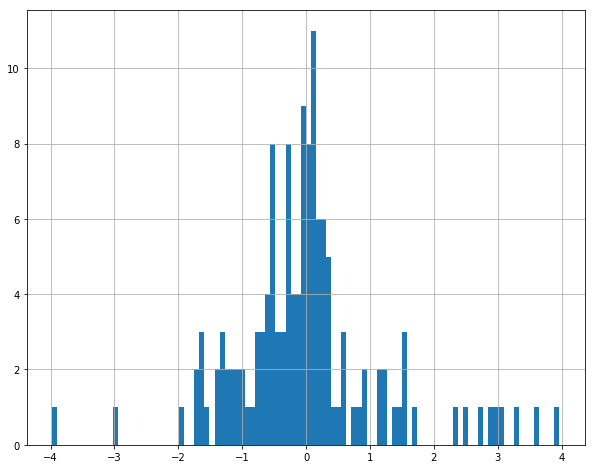

In [15]:
df.z_shifted.hist(bins=100)
plt.show()

In [24]:
dfs = load_directory('../vertex_finding/data/train/', max_files=10)

100%|██████████| 10/10 [00:04<00:00,  1.99it/s]


In [35]:
def filter_clusters(df, inplace=False):
    df = df.query('cluster_idx >= 0 and mcpvprods > 10', inplace=inplace)
    return df

In [36]:
for df in dfs:
    predict_cluster(df)
    add_vertex_info(df)
    filter_clusters(df, inplace=True)

In [43]:
print(*df.columns, sep='\',\n\'')

LHCbIDs',
'MCPs',
'isBackwards',
'key',
'x',
'y',
'z',
'dx',
'dy',
'cov_x',
'cov_y',
'cov_dx',
'cov_dy',
'cov_xdx',
'event',
'run',
'mcpx',
'mcpy',
'mcpz',
'mcpvid',
'mcpvprods',
'rho',
'cluster_idx',
'cluster_x',
'cluster_y',
'cluster_z',
'x_shifted',
'y_shifted',
'z_shifted


In [54]:
features = [
    'x',
    'y',
    'z',
    'dx',
    'dy',
    'cov_x',
    'cov_y',
    'cov_dx',
    'cov_dy',
    'cov_xdx',
    'rho',
    'x_shifted',
    'y_shifted',
    'z_shifted',
]

In [174]:
def get_Xy_data(df, max_tracks=500):
    """ Transform our nice dataframes to numpy arrays of track features per cluster
    and MC vertex positions.
    """
    clusters = []
    mc_vertices = []
    for cluster in df.cluster_idx.unique():
        X = df.loc[df.cluster_idx == cluster, features].values
        X = np.pad(X, ((0, max_tracks - X.shape[0]), (0, 0)), mode='constant')
        clusters.append(X)
        mc_vertices.append(df.loc[df.cluster_idx == cluster, ['mcpx', 'mcpy', 'mcpz']].iloc[0].values)
        
    return np.array(clusters), np.array(mc_vertices)

In [242]:
Xs = ys = None

In [243]:
for df in dfs:
    X, y = get_Xy_data(df)
    if Xs is None:
        Xs = X
        ys = y
    else:
        Xs = np.append(Xs, X, axis=0)
        ys = np.append(ys, y, axis=0)

In [248]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Input

In [249]:
model = Sequential()

model.add(GRU(50))
model.add(Dense(3, activation='softmax'))

In [250]:
model.compile('sgd', loss=keras.losses.categorical_crossentropy)

In [251]:
model.fit(Xs, ys)

Epoch 1/1
18/18 [==============================] - 1s 62ms/step - loss: -61.2160


In [225]:
model.predict(Xs)

array([[  0.36908199,   0.47715163, 112.3317664 ],
       [  0.38448199,   0.45565163,  64.2655664 ],
       [  0.41178202,   0.47835163, -48.8144336 ],
       [  0.41348202,   0.51195163,  86.0628664 ],
       [  0.41558199,   0.43965163, 146.2747664 ],
       [  0.42598199,   0.49675163, 101.8971664 ],
       [  0.38628199,   0.48115163,   0.2781664 ],
       [  0.36298199,   0.50275163, 169.4736664 ],
       [  0.41808199,   0.47215163, -22.97853359],
       [  0.44458199,   0.50515163,  23.5076664 ],
       [  0.45018196,   0.50445163,  32.73866641],
       [  0.41248199,   0.47235163, 146.9615664 ],
       [  0.39608202,   0.47225163,  61.9501664 ],
       [  0.40188202,   0.46205163,  -1.2468336 ],
       [  0.40668202,   0.50065163, 123.6020664 ],
       [  0.42078202,   0.45315163, -46.7066336 ],
       [  0.46538199,   0.47565163, 150.92606641],
       [  0.43058199,   0.48255163, -95.60203359]])